<div style="padding: 6px 12px 18px 12px; background: #eeffee; border: 2px solid #88aa88; border-radius: 4px;">

<h2>Installing Devito (do not include in manuscipt)</h2>

<p>This tutorial and the coming second part are based on Devito version 3.1.0. It requires the installation of the full software with examples, not only the code generation API. To install:</p>

<pre style="background: #eeffee;">
git clone -b v3.1.0 https://github.com/opesci/devito
cd devito
conda env create -f environment.yml
source activate devito
pip install -e .
</pre>

<p>That final dot is important, don't miss it out!</p>

<h2>Installing Julia</h2>

<p>Users need to install Julia, then the [JUDI] software package, [JOLI](https://github.com/slimgroup/JOLI.jl), and [SeisIO]. These packages can be downloaded using the Julia package manager. First install Julia 0.6, then start the Julia terminal and do this:</p>

<pre style="background: #eeffee;">
ENV["PYTHON"] = "/Users/matt/anaconda/envs/devito/bin/python"
Pkg.add("IJulia")
Pkg.add("HDF5")
Pkg.add("PyCall")
Pkg.clone("https://github.com/slimgroup/SeisIO.jl.git")
Pkg.clone("https://github.com/slimgroup/JOLI.jl.git")
Pkg.clone("https://github.com/slimgroup/JUDI.jl.git")
</pre>

<h2>Useful links</h2>
<ul>
<li><a href="http://www.opesci.org/">Devito documentation</a></li>
<li><a href="https://github.com/opesci/Devito">Devito source code and examples</a></li>
<li><a href="https://github.com/opesci/Devito/examples/seismic/tutorials">Tutorial notebooks with latest Devito/master</a></li>
</ul>

</div>

### Geophysics tutorial


# Full-Waveform Inversion - Part 3: optimization

Philipp Witte<sup>1</sup>\*, Mathias Louboutin<sup>1</sup>, Keegan Lensink<sup>1</sup>, Michael Lange<sup>2</sup>, Navjot Kukreja<sup>2</sup>, Fabio Luporini<sup>2</sup>, Gerard Gorman<sup>2</sup>, and Felix J. Herrmann<sup>1,3</sup>

<sup>1</sup> Seismic Laboratory for Imaging and Modeling (SLIM), The University of British Columbia 

<sup>2</sup> Imperial College London, London, UK

<sup>3</sup> now at Georgia Institute of Technology, USA 

Corresponding author: pwitte@eoas.ubc.ca

## Introduction

This tutorial is the third part of a full-waveform inversion (FWI) tutorial series with a step-by-step walkthrough of setting up forward and adjoint wave equations and building a basic FWI inversion framework. For discretizing and solving wave equations, we use [Devito], a Python-based domain-specific language for automated generation of finite-difference code (Lange et al., 2016). The first two parts of this tutorial (Louboutin et al., 2017, 2018) demonstrated how to solve the acoustic wave equation for modeling seismic shot records and how to compute the gradient of the FWI objective function using the adjoint-state method. With these two key ingredients, we will now build an inversion framework that can be used to minimize the FWI least-squares objective function.

[Devito]:http://www.opesci.org/devito-public
[Julia]:https://julialang.org
[JUDI]:https://github.com/slimgroup/JUDI.jl

As an optimization problem, FWI can be quite challenging, both computationally and mathematically. The computational complexity comes from the fact that an already expensive solution procedure for the wave equation needs to be repeated for a large number of source positions for each iteration of the optimization algorithm. The mathematical complexity comes from the fact that the FWI objective is known to have many local minima due to cycle skipping. Furthermore, since the solution is not unique it is generally not possible to unambiguously recover the parametrization of the subsurface from the given data alone, making FWI an active field of research (e.g. Leeuwen et al., 2013; Warner and Guasch, 2014; Peters and Herrmann, 2017). This tutorial demonstrates how we can set up a basic FWI framework with gradient-based optimization algorithms, such as steepest descent and the Gauss-Newton method (Nocedal and Wright, 2009). Building a full FWI framework with routines for data IO and data parallelization is beyond the scope of a single tutorial, therefore we will implement our inversion framework with the [Julia Devito Inversion framework](https://github.com/slimgroup/JUDI.jl) (JUDI),  a parallel software package for seismic modeling and inversion in [Julia](Bezanson et al., 2012). JUDI provides abstractions and function wrappers that allow the implementation of wave-equation-based inversion problems such as FWI using code that closely follows the mathematical notation, while using Devito’s automatic code generation for solving the underlying wave equations.

## Optimizing the full-waveform inversion objective function

The goal of this tutorial series is to optimize the FWI objective function with the $\ell_2$-misfit:

$$
	\mathop{\hbox{minimize}}_{\mathbf{m}} \hspace{.2cm} f(\mathbf{m})= \sum_{i=1}^{n_s} \frac{1}{2} \left\lVert \mathbf{d}^\mathrm{pred}_i (\mathbf{m}, \mathbf{q}_i) - \mathbf{d}_i^\mathrm{obs} \right\rVert_2^2,
$${#FWI}

where $\mathbf{d}^\mathrm{pred}_i$ and $\mathbf{d}^\mathrm{obs}_i$ are the predicted and observed seismic shot records of the $i^{\text{th}}$ source location and $\mathbf{m}$ is the velocity model in squared slowness. In part one, we demonstrated how to implement a forward modeling operator to generate the predicted shot records, which we will denote as $\mathbf{d}^\mathrm{pred}_i = \mathbf{F}(\mathbf{m},\mathbf{q}_i)$. 
In the second tutorial, we then showed how we can compute the gradient $\nabla f(\mathbf{m})$ of the objective function and update our initial model using gradient descent (GD). This first-order optimization algorithm has, at best, a linear convergence rate and typically requires many iterations. For this reason, second-order optimization methods are of interest, since they converge considerably faster (with up to quadratic convergence rate), assuming that the starting model $\mathbf{m}_0$ is good and there is no cycle skipping. For second order methods, we approximate the objective with a second-order Taylor expansion:

$$
	f(\mathbf{m}) = f(\mathbf{m}_0) + \nabla f(\mathbf{m}_0) \delta \mathbf{m} + \delta \mathbf{m}^\top \nabla^2 f(\mathbf{m}_0) \delta \mathbf{m} + \mathcal{O}(\delta \mathbf{m}^3),
$${#Taylor}

where $\nabla f(\mathbf{m}_0)$ is the gradient as implemented in part two and $\nabla^2 f(\mathbf{m}_0)$ is the Hessian of the objective function, which we will from now on refer to as $\mathbf{H}$ (omitting the model dependence). Rather than simply using the negative gradient to update our model, we can directly calculate a model update $\delta \mathbf{m}$ that leads us to the minimum of the quadratic Taylor approximation (Newton's method):

$$
	\delta \mathbf{m} = - \mathbf{H}(\mathbf{m}_0)^{-1} \nabla f(\mathbf{m}_0).
$${#newton}

Although Newton's method converges to the minimum of the FWI objective function very fast, this comes at the cost of having to compute and invert the Hessian matrix (Nocedal and Wright, 2009). For least squares problems, such as FWI, the Hessian can be approximated by the Gauss-Newton (GN) Hessian $\mathbf{J}^\top \mathbf{J}$, where $\mathbf{J}$ is the Jacobian matrix, which is the partial derivative of the forward modeling operator $\mathbf{F}(\mathbf{m},\mathbf{q})$ with respect to $\mathbf{m}$. The Jacobian can also be used to express the gradient of the FWI objective function as $\nabla f(\mathbf{m}_0) = \mathbf{J}^\top (\mathbf{d}^\mathrm{pred}_i - \mathbf{d}_i^\mathrm{obs})$, where $\mathbf{J}^\top$ is the adjoint (transposed) Jacobian. This is useful, because we now have a set of operators $\mathbf{F}, \mathbf{J}$ and $\mathbf{H}_{GN}=\mathbf{J}^\top\mathbf{J}$, through which we can express both first and second order optimization algorithms for FWI. However, forming these matrices explicitly is not possible, since they can become extremely large. Luckily, we only need the action of these operators on vectors, which allows us to implement these operators matrix-free. In the following section we will demonstrate how to set up these operators in our JUDI software framework and to how to use them to implement FWI algorithms.

## The Julia Devito Inversion framework and SeisIO

[SeisIO]:https://github.com/slimgroup/SeisIO.jl

The Julia Devito Inversion framework is a parallel matrix-free linear operator library for seismic modeling and inversion based on Devito and [SeisIO], a performant Julia package for reading and writing large data volumes in SEG-Y format. JUDI allows implementing seismic inversion algorithms as linear algebra operations, enabling rapid translations of FWI algorithms to executable Julia code. The underlying wave equations are set up and solved using Devito, as described in the first two tutorials, and are interfaced from Julia using the [PyCall](https://github.com/JuliaPy/PyCall.jl) package (Johnson, 2017). 

We start our demonstration by reading the initial model and our data set, which consists of $16$ shot records and was generated with an excerpt from the 2D Overthrust model. For reading and writing SEG-Y data, JUDI uses the SeisIO package, a sophisticated SEG-Y reader that allows us to scan large 3D data sets for creating look-up tables with header summaries. However, since our data set is relatively small, we will directly load the full file into memory. The `segy_read` command takes the file name as an input and returns a dense data block. This is our observed data and we store it as a JUDI vector: 

In [1]:
# NOT FOR MANUSCRIPT
addprocs(4);

In [2]:
# NOT FOR MANUSCRIPT
using SeisIO
using JUDI.TimeModeling, JUDI.SLIM_optim

In [3]:
block = segy_read("overthrust_shot_records.segy")
d_obs = judiVector(block);

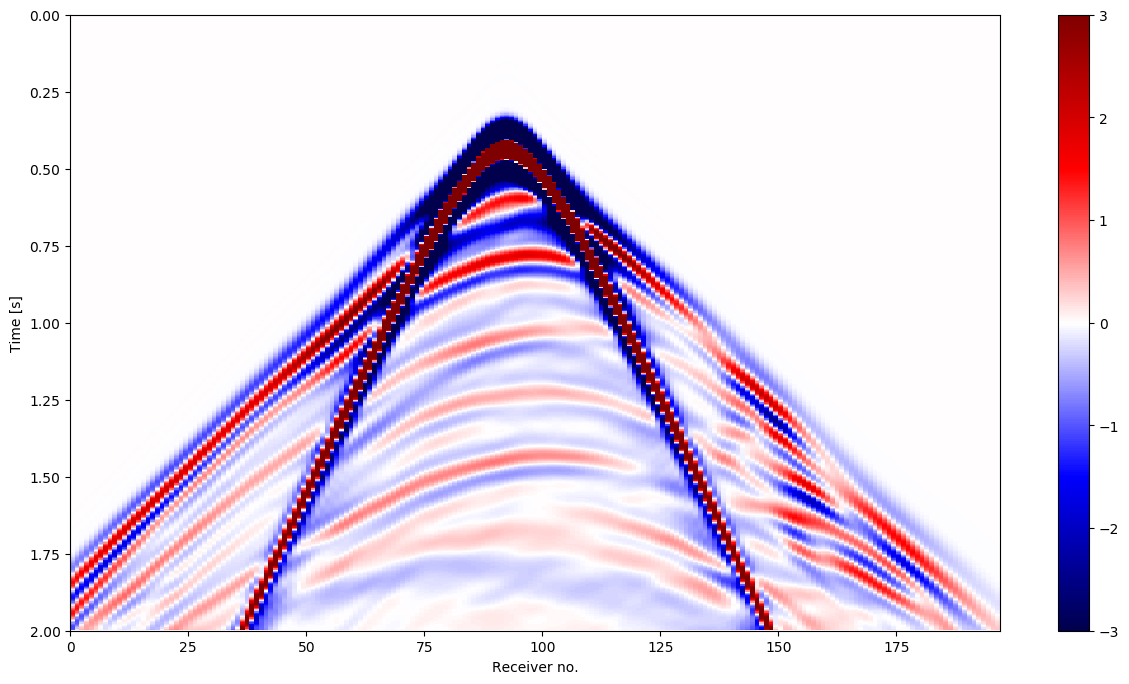

In [4]:
# NOT FOR MANUSCRIPT
using PyPlot

figure(figsize=(15,8))
imshow(d_obs.data[8], cmap="seismic", extent=[0,size(d_obs.data[8],2),2,0], aspect=0.3, vmin=-3, vmax=3)
ax1 = gca(); ax1[:set_aspect]("auto"); xlabel("Receiver no."); ylabel("Time [s]")
colorbar()
show()

> **Figure 1**: Observed shot record number 8.

JUDI vectors such as `d_obs` can be used like a regular Julia vectors, so we can compute norms via `norm(d_obs)` or the inner product via `dot(d_obs, d_obs)`, but they contain the shot records in their original dimension. Shot records can be accessed via their respective shot number with `d_obs.data[shot_no]`, while the header information can be accessed with `d_obs.geometry`. Since a SEG-Y file contains the source coordinates, but not the source wavelet itself, we extract the source geometry from our file and then manually set up a source vector `q` with a $8$ Hertz Ricker wavelet:

In [5]:
src_geometry = Geometry(block; key="source")
src_data = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.008)
q = judiVector(src_geometry, src_data);

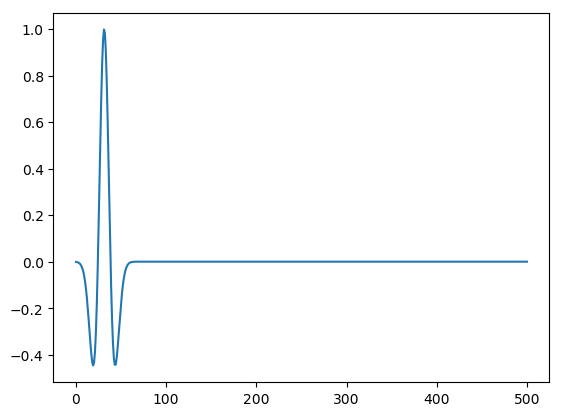

In [6]:
# NOT FOR MANUSCRIPT
plot(q.data[1])
show()

Since our data set consists of $16$ shot records, both `d_obs` and `q` contain the data and geometries for all source positions. We can check the number of source positions with `d_obs.nsrc` and `q.nsrc` and we can extract the part of the vector that corresponds to one or multiple shots with `d_obs[shot_no], q[shot_no]`. 

We will now set up the forward modeling operator $F(\mathbf{m},\mathbf{q})$ as a matrix-free operator for the inverse wave equation $\mathbf{A}(\mathbf{m})^{-1}$, where $\mathbf{m}$ is the current model, and source/receiver injection and sampling operators $\mathbf{P}_s$ and $\mathbf{P}_r$. This allows us to express modeling of a shot record as `d_pred = Pr*Ainv*Ps'*q`. The `Pr` and `Ps` can be considered as matrix-free operators around the Devito sparse point injection and interpolation (Louboutin et al., 2017). Multiplications with `Ps` and `Pr` represent sampling the wavefield at source/receiver locations, while their adjoints `Pr', Ps'` denote injecting either shot records or source wavelets into the computational grid. Since the dimensions of the inverse wave equation operator depend on the number of computational time steps, we calculate this number using the `get_computational_nt` function and set up an `info` object that contains some dimensionality information required by all operators. The projection and modelling operators can then be set up in Julia in the following way:

In [7]:
using HDF5

m0, n, d, o = read(h5open("overthrust_model.h5","r"),"m0","n","d","o")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

In [9]:
ntComp = get_computational_nt(q.geometry, d_obs.geometry, model0)
info = Info(prod(model0.n), d_obs.nsrc, ntComp)
Pr = judiProjection(info, d_obs.geometry)
Ps = judiProjection(info, q.geometry)
Ainv = judiModeling(info, model0);

We can forward model all $16$ predicted shot records by running `d_pred = Pr*Ainv*Ps'*q` from the Julia command line, which is equivalent to the mathematical expression $F(\mathbf{m};\mathbf{q})=\mathbf{P}_r\mathbf{A}^{-1}(\mathbf{m})\mathbf{P}_s^\top\mathbf{q}$ by virtue of the instantiation `Ainv = judiModeling(info, model0)`, which makes the wave equation solver implicitly dependent on the `model`. If we started our Julia session with multiple CPU cores or nodes (`julia -p n`, with `n` being the number of workers), the wave equation solves are automatically parallelized over source locations and all shots are collected in the `d_pred` vector. We can also model a single or subset of shots by indexing the operators with the respective shot numbers. E.g. if we want to model the first two shots, we define `i=[1,2]` and then run `d_sub = Pr[i]*Ainv[i]*Ps[i]'*q[i]`. **Remark.** If we want to solve an adjoint wave equation with the observed data as the adjoint source and restrictions of the wavefields back to the source locations, we can simply run `qad = Ps*Ainv'*Pr'*d_obs`, exemplifying the advantages of casting FWI in a proper computational linear algebra framework.

Finally, we set up the matrix-free Jacobian operator `J` and the Gauss-Newton Hessian `J'*J`. As mentioned in the introduction, `J` is the partial derivative of the forward modeling operator `F` with respect to the model `m` and is therefore directly constructed from our modeling operator `Pr*Ainv*Ps'` and a specified source vector `q`:

In [10]:
J = judiJacobian(Pr * Ainv * Ps', q)
H_GN = J' * J    # Gauss-Newton Hessian.
i = 10           # Choose shot 10.
d_pred = Pr[i] * Ainv[i] * Ps[i]' * q[i]
g = J[i]' * (d_pred - d_obs[i]);

In the context of seismic inversion, the Jacobian is also called the linearized modeling or demigration operator and its adjoint `J'` is the migration operator. One drawback of this notation is that the forward wavefields for the gradient calculation have to be recomputed, since the forward modeling operator only returns the shot records and not the complete wavefields. For this reason, JUDI has an additional function for computing the gradients of the FWI objective function `f,g = fwi_objective(model0,q[i],d_obs[i])`, which takes the current model, source and data vectors as an input and computes the objective value and gradient in parallel without having to recompute the forward wavefields.


## Full-waveform inversion with JUDI

With expressions for modeling operators, Jacobians and gradients of the FWI objective, we can now implement different FWI algorithms in a few lines of code. We will start with a basic gradient descent (GD) example with a line search. To reduce the computational cost of full gradient descent (GD), we will use a stochastic approach (SGD) in which we only compute the gradient and function value for a randomized subset of source locations. In JUDI, this is accomplished by choosing a random vector of integers between 1 and 16 and indexing the data vectors as described earlier. Furthermore, we will apply box constraints to the updated model, to prevent velocities (or squared slownesses) to become negative or too large. Bound constraints are applied to the updated model trough a projection operator `proj(x)`, which clips values of the slowness that lie outside the allowed range. The full algoritm for FWI with stochastic gradient descent and box constraints is implemented as follows:

In [11]:
# NOT FOR MANUSCRIPT
# Set up bound constraints.
v0 = sqrt.(1f0./model0.m)
vmin = ones(Float32, model0.n)*1.3f0;
vmax = ones(Float32, model0.n)*6.5f0;

# Fix water column.
vmin[:,1:21] = v0[:,1:21];
vmax[:,1:21] = v0[:,1:21];

# Convert to squared slowness.
mmin = vec((1f0./vmax).^2);
mmax = vec((1f0./vmin).^2);

In [ ]:
# NOT FOR MANUSCRIPT
maxiter = 10
batchsize = 8    # Number of shots for each iteration.
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)],2), model0.n)

In [12]:
for j=1:maxiter
    # FWI objective function value and gradient.
    i = randperm(d_obs.nsrc)[1:batchsize]  # Random source locations.
    fval, grad = fwi_objective(model0, q[i], d_obs[i])

    # Line search and update model.
    update = backtracking_linesearch(model0,
                                     q[i],
                                     d_obs[i],
                                     fval,
                                     grad,
                                     proj;
                                     alpha=1f0)
    model0.m += reshape(update, model0.n)

    # Apply box constraints.
    model0.m = proj(model0.m)
end

The function `backtracking_linesearch` performs an approximate line search and returns a model update that leads to a sufficient decrease of the FWI function value (Armijo condition, Nocedal and Wright, 2009) and is part of the JUDI optimization sub-module `JUDI.SLIM_optim`. The result after 10 iterations of SGD with box constraints is shown in Figure 2. In practice, where starting models are typically less accurate than in our example, FWI is often performed from low to high frequencies, since the objective function has less local minima for lower frequencies (Bunks et al., 1995). In this multi-scale FWI approach, a low-pass filtered version of the data is used to invert for a low resolution velocity model first and higher frequencies are added in subsequent iterations.

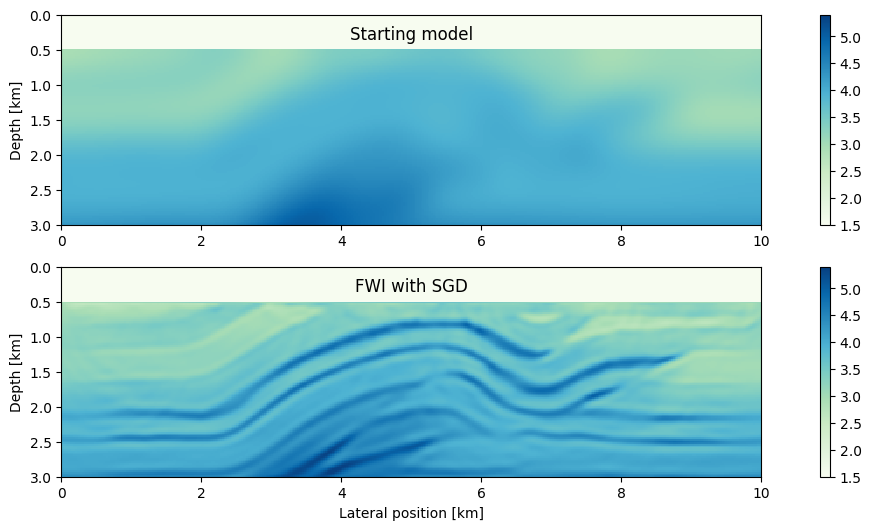

In [26]:
# NOT FOR MANUSCRIPT
figure(figsize=(15, 6))

subplot(211)
imshow(sqrt.(1f0./m0)', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4)
text(5, 0.35, "Starting model", ha="center", size=12)
ylabel("Depth [km]")
colorbar()

subplot(212)
imshow(sqrt.(1f0./model0.m)', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4)
text(5, 0.35, "FWI with SGD", ha="center", size=12)
xlabel("Lateral position [km]")
ylabel("Depth [km]")
colorbar()

show()

> **Figure 2**: Initial model and recovered velocity model after 10 iterations of stochastic gradient descent with box constraints and a batch size of 8 shots.

In [28]:
# NOT FOR MANUSCRIPT
model0.m = m0    # Reset velocity model.
fhistory_GN = zeros(Float32,maxiter);

In [ ]:
using IterativeSolvers

for j=1:maxiter
    # Model predicted data.
    d_pred = Pr * Ainv * Ps' * q

    # GN update direction.
    p = lsqr(J, d_pred - d_obs; maxiter=6)
    fhistory_GN[j] = .5f0 * norm(d_pred - d_obs)^2  # OMIT LINE FROM MANSCRIPT

    # update model and box constraints.
    model0.m = proj(model0.m - reshape(p, model0.n))  # alpha=1
end

An important benefit of matrix-free operators is that we do not need to implement our own `LSQR` solver, but can pass `J` and the data residual `d_pred - d_obs` to a third-party optimization library. The operator `J` does not need to be an explicit matrix, since `LSQR` only uses matrix-vector products. However, in contrast to our SGD algorithm, we use all shot records in every iteration, since stochastic methods for second order algorithms are less well understood, making this approach considerably more expensive than our previous algorithm.

In [ ]:
# NOT FOR MANUSCRIPT
imshow(sqrt.(1f0./model0.m)', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4)
title("FWI with GN method")
xlabel("Lateral position [km]")
ylabel("Depth [km]")
show()

> **Figure 3**: Recovered velocity model after 10 iterations of the Gauss-Newton method as shown above, with 6 iterations of `LSQR` for the GN subproblem and using all shots in every iteration.

In [ ]:
# NOT FOR MANUSCRIPT
fhistory_SG = fhistory/norm(fhistory,Inf);
fhistory_GN = fhistory_GN/norm(fhistory_GN,Inf);

plot(1:10, fhistory_SG, 1:10, fhistory_GN);
xlabel("Iteration no."); ylabel("Normalized function value");

> **Figure 4**: Normalized function values for the FWI inversion example with stochastic gradient descent and the Gauss-Newton method.

An alternative to (Gauss-) Newton methods are Quasi-Newton methods, which build up an approximation of the Hessian from previous gradients only and require no additional PDE solves or matrix inversions. Implementing an efficient and correct version of this method, such as the L-BFGS algorithm, exceeds a few lines of code and we therefore leave this exercise to the reader. Instead of implementing more complicated algorithms by hand, it is also possible to interface third-party Julia optimization libraries and an example for this is given in the notebook **fwi_overthrust_NLopt.jl**. Even though all examples shown here are two-dimensional, in order to make them reproducible on a laptop or desktop PC, JUDI can be used for 3D modeling and inversion without having to change the code, since the number of dimensions are automatically inferred from the velocity model and data dimensions.


## Conclusions

In this final part of our FWI tutorial series, we demonstrated how to set up basic optimization algorithms for waveform inversion using JUDI. The methods shown here are all gradient based and differ in the way how update directions for the velocity model are computed. Our numerical examples can serve for the reader as a basis for developing more advanced FWI workflows, which usually include additional data preprocessing, frequency continuation techniques or further model constraints.



## Acknowledgments

This research was carried out as part of the SINBAD II project with the support of the member organizations of the SINBAD Consortium. This work was financially supported in part by EPSRC grant EP/L000407/1 and the Imperial College London Intel Parallel Computing Centre.


## References

Bezanson, J., Karpinski, S., Shah, V. B., and Edelman, A., 2012, Julia: A fast dynamic language for technical computing: CoRR. Retrieved from http://arxiv.org/abs/1209.5145

Bunks, C., Saleck, F. M., Zaleski, S., and Chavent, G., 1995, Multiscale seismic waveform inversion: GEOPHYSICS, 60, 1457–1473. doi:10.1190/1.1443880

Johnson, S., 2017, Calling python functions from the julia language: GitHub repository. https://github.com/JuliaPy/PyCall.jl; GitHub.

Lange, M., Kukreja, N., Louboutin, M., Luporini, F., Zacarias, F. V., Pandolfo, V., … Gorman, G., 2016, Devito: Towards a generic finite difference DSL using symbolic python: 6th workshop on python for high-performance and scientific computing. doi:10.1109/PyHPC.2016.9

Leeuwen, T. van, Aravkin, A. Y., Calandra, H., and Herrmann, F. J., 2013, In which domain should we measure the misfit for robust full waveform inversion? EAGE annual conference proceedings. doi:10.3997/2214-4609.20130839

Louboutin, M., Witte, P. A., Lange, M., Kukreja, N., Luporini, F., Gorman, G., and Herrmann, F. J., 2017, Full-waveform inversion - part 1: Forward modeling: Retrieved from https://www.slim.eos.ubc.ca/Publications/Private/Submitted/2017/louboutin2017fwi/louboutin2017fwi.html

Louboutin, M., Witte, P. A., Lange, M., Kukreja, N., Luporini, F., Gorman, G., and Herrmann, F. J., 2018, Full-waveform inversion - part 2: Adjoint modeling:

Nocedal, J., and Wright, S., 2009, Numerical optimization: (2nd ed.). Springer.

Paige, C. C., and Saunders, M. A., 1982, LSQR: An algorithm for sparse linear equations and sparse least squares: ACM Trans. Math. Softw., 8, 43–71. doi:10.1145/355984.355989

Peters, B., and Herrmann, F. J., 2017, Constraints versus penalties for edge-preserving full-waveform inversion: The Leading Edge, 36, 94–100. doi:10.1190/tle36010094.1

Warner, M., and Guasch, L., 2014, Adaptive waveform inversion: Theory: In SEG technical program expanded abstracts 2014 (pp. 1089–1093). doi:10.1190/segam2014-0371.1